In [9]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from alpaca.trading.client import TradingClient
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [10]:
# Read monthly returns file
msr = pd.read_csv(r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7053 Algorithmic Trading\Data Storage\beta_ivol.csv")

# Read monthly risk free file
mrf = pd.read_csv(r"C:\Users\Jonbf5\OneDrive - University of Cincinnati\Classes\FIN7053 Algorithmic Trading\Data Storage\ff-monthly.csv")

In [11]:
import pandas as pd

# Inspect original date values and column names
print(" msr.columns:", msr.columns)
print(" First 5 dates:", msr['date'].head())

# Try parsing the date safely (auto format detection)
msr['date'] = pd.to_datetime(msr['date'], errors='coerce')

# Drop rows where parsing failed
msr = msr.dropna(subset=['date'])

# Convert to monthly period AFTER parsing
msr['month'] = msr['date'].dt.to_period('M')

# Preview unique months
print(" Parsed months:", msr['month'].unique()[:5])
print("Total rows after parsing date:", len(msr))

 msr.columns: Index(['date', 'PERMNO', 'beta', 'ivol', 'RET'], dtype='object')
 First 5 dates: 0    2015-01-30
1    2015-02-27
2    2015-03-31
3    2015-04-30
4    2015-05-29
Name: date, dtype: object
 Parsed months: <PeriodArray>
['2015-01', '2015-02', '2015-03', '2015-04', '2015-05']
Length: 5, dtype: period[M]
Total rows after parsing date: 458300


Strategy 1: Betting Against Beta
In our first practice strategy we can see a sharpe of 0.5654 which exceeds the 0.4 we expect from the market. The Max Drawdown was about 24.86%. Not a bad strategy but it stopped being effective halfway through 2021. Its effectivness before that point may have stemmed from how hard Covid hit the whole market, so having a low beta would have been very beneficial. But once the market turned around that benefit faded.

 Strategy completed.
 Sharpe Ratio: 0.5654
 Max Drawdown: -0.2486


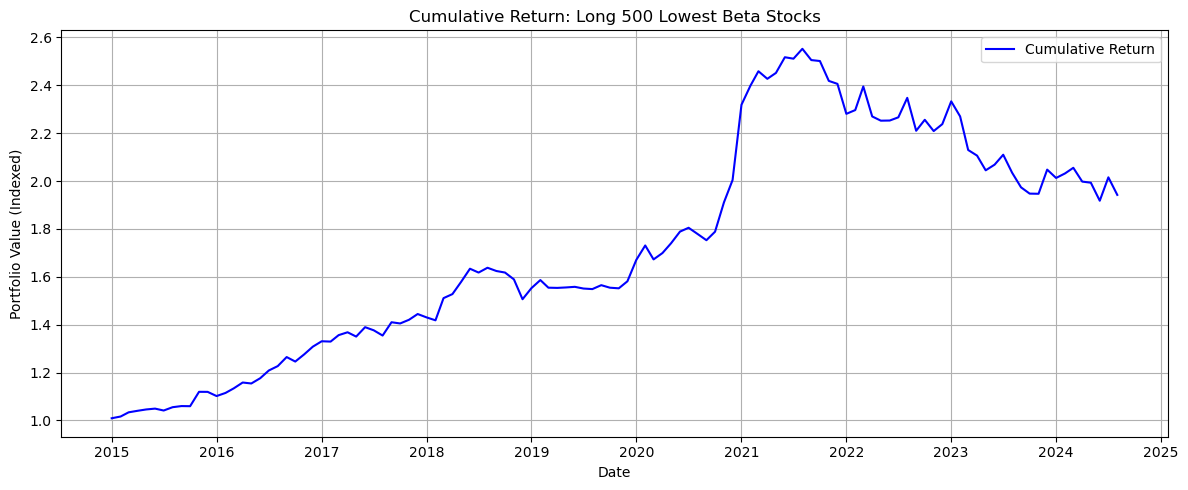

In [12]:
#Strategy 1

# Parse and convert to period
mrf['date'] = pd.to_datetime(mrf['dateff'], errors='coerce')
mrf = mrf.dropna(subset=['date'])
mrf['month'] = mrf['date'].dt.to_period('M')

# Clean and deduplicate
mrf['rf'] = pd.to_numeric(mrf['rf'], errors='coerce')
mrf = mrf.dropna(subset=['rf'])
mrf = mrf[['month', 'rf']].drop_duplicates()

# === Merge clean msr with clean mrf ===

# Ensure msr['month'] exists (from previous step)
# Drop rows missing RET, beta before strategy
msr = msr.dropna(subset=['RET', 'beta'])

# Merge on month
merged = pd.merge(msr, mrf, on='month', how='left')

# Drop any rows missing rf (merge failures)
merged = merged.dropna(subset=['rf'])

# === Run Strategy: Long 500 Lowest Beta Stocks per Month ===

monthly_returns = []

for month in sorted(merged['month'].unique()):
    df_month = merged[merged['month'] == month]
    
    if len(df_month) < 300:  # More realistic floor
        continue

    low_beta = df_month.nsmallest(500, 'beta')
    
    avg_ret = low_beta['RET'].mean()
    rf = low_beta['rf'].iloc[0]
    excess_ret = avg_ret - rf

    monthly_returns.append({
        'date': month.to_timestamp(),
        'ret': avg_ret,
        'excess_ret': excess_ret
    })

# === Compile Results ===

strategy_df = pd.DataFrame(monthly_returns)
strategy_df.set_index('date', inplace=True)

# Sharpe and Drawdown
sharpe_ratio = strategy_df['excess_ret'].mean() / strategy_df['excess_ret'].std() * np.sqrt(12)
strategy_df['cum_ret'] = (1 + strategy_df['ret']).cumprod()
strategy_df['peak'] = strategy_df['cum_ret'].cummax()
strategy_df['drawdown'] = (strategy_df['cum_ret'] - strategy_df['peak']) / strategy_df['peak']
max_drawdown = strategy_df['drawdown'].min()

# === Output ===
print(" Strategy completed.")
print(f" Sharpe Ratio: {sharpe_ratio:.4f}")
print(f" Max Drawdown: {max_drawdown:.4f}")

# === Plot ===
plt.figure(figsize=(12, 5))
plt.plot(strategy_df.index, strategy_df['cum_ret'], label='Cumulative Return', color='blue')
plt.title('Cumulative Return: Long 500 Lowest Beta Stocks')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Indexed)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Strategy 2: Avoiding Idiosyncratic Vol
Strategy 2 beat out strategy 1 in all areas. The Sharpe was about 0.6887 with a slightly lower drawdown of 24.23%. The cumulative return was also far better at about (2.75) compared to Strat 1 (1.95). Strat 2 also looks like it took a hit in the Covid year but overall is continuing to perform well.

 IVOL Strategy completed.
 Sharpe Ratio (Low IVOL): 0.6887
 Max Drawdown (Low IVOL): -0.2423


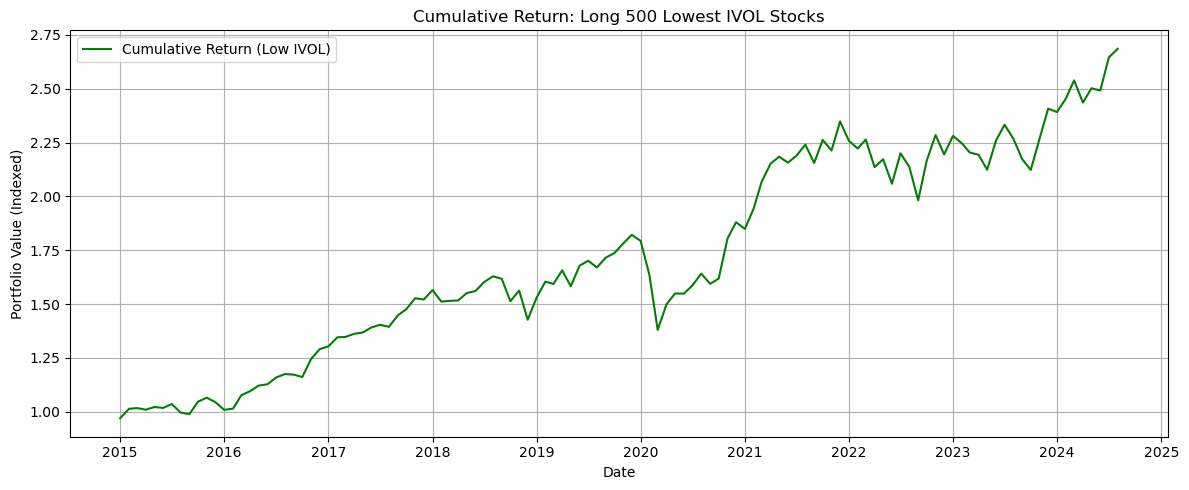

In [15]:
# === Strategy 2: Long 500 Lowest IVOL Stocks Each Month ===

monthly_returns_ivol = []

for month in sorted(merged['month'].unique()):
    df_month = merged[merged['month'] == month]
    
    if len(df_month) < 300:
        continue

    #  Sort by 'ivol' instead of 'beta'
    low_ivol = df_month.nsmallest(500, 'ivol')
    
    avg_ret = low_ivol['RET'].mean()
    rf = low_ivol['rf'].iloc[0]
    excess_ret = avg_ret - rf

    monthly_returns_ivol.append({
        'date': month.to_timestamp(),
        'ret': avg_ret,
        'excess_ret': excess_ret
    })

# === Compile Results ===

ivol_df = pd.DataFrame(monthly_returns_ivol)
ivol_df.set_index('date', inplace=True)

# Performance metrics
sharpe_ratio_ivol = ivol_df['excess_ret'].mean() / ivol_df['excess_ret'].std() * np.sqrt(12)
ivol_df['cum_ret'] = (1 + ivol_df['ret']).cumprod()
ivol_df['peak'] = ivol_df['cum_ret'].cummax()
ivol_df['drawdown'] = (ivol_df['cum_ret'] - ivol_df['peak']) / ivol_df['peak']
max_drawdown_ivol = ivol_df['drawdown'].min()

# === Output ===
print(" IVOL Strategy completed.")
print(f" Sharpe Ratio (Low IVOL): {sharpe_ratio_ivol:.4f}")
print(f" Max Drawdown (Low IVOL): {max_drawdown_ivol:.4f}")

# === Plot ===
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(ivol_df.index, ivol_df['cum_ret'], label='Cumulative Return (Low IVOL)', color='green')
plt.title('Cumulative Return: Long 500 Lowest IVOL Stocks')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Indexed)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Strategy 3: Combining 1 & 2
Through the Sharpe optimization strategy using both of the strategies above we achieve our best Sharpe yet with the 50/50 mix getting 0.7601, and the optimal sharpe being 0.7642. The strategies above look to be correlated by about 0.3816. The results follow what we know about blending uncorrelated stratgies, which is as we continue to add uncorrelated strategies we will continue pushing Sharpe towards infinity. 

In [18]:
import numpy as np
import pandas as pd

# === Step 1: Align both strategies by date
combined = pd.merge(
    strategy_df[['ret', 'excess_ret']],
    ivol_df[['ret', 'excess_ret']],
    left_index=True,
    right_index=True,
    suffixes=('_beta', '_ivol')
).dropna()

# === Strat 3 (a): Correlation between returns
correlation = combined['ret_beta'].corr(combined['ret_ivol'])

# === Strat 3 (b): 50/50 portfolio Sharpe ratio

# Equal-weighted returns
combined['ret_5050'] = 0.5 * (combined['ret_beta'] + combined['ret_ivol'])
combined['excess_5050'] = 0.5 * (combined['excess_ret_beta'] + combined['excess_ret_ivol'])

sharpe_5050 = combined['excess_5050'].mean() / combined['excess_5050'].std() * np.sqrt(12)

# === Q3 (c): Optimal weights to maximize Sharpe ratio

# Build return matrix (excess returns only)
excess_matrix = combined[['excess_ret_beta', 'excess_ret_ivol']].values

# Calculate mean and covariance
mean_vec = excess_matrix.mean(axis=0)
cov_matrix = np.cov(excess_matrix.T)

# Use formula for maximum Sharpe ratio weights: w* ∝ Σ⁻¹μ
inv_cov = np.linalg.inv(cov_matrix)
weights_optimal = inv_cov @ mean_vec
weights_optimal = weights_optimal / weights_optimal.sum()

# Portfolio Sharpe with optimal weights
excess_opt = excess_matrix @ weights_optimal
sharpe_opt = excess_opt.mean() / excess_opt.std() * np.sqrt(12)

# === Output ===

print(" Q3 Results:")
print(f" (a) Correlation between strategies: {correlation:.4f}")
print(f" (b) Sharpe Ratio (50/50 Portfolio): {sharpe_5050:.4f}")
print(f" (c) Optimal Weights (Sharpe-Maximizing):")
print(f"    - Low Beta: {weights_optimal[0]:.4f}")
print(f"    - Low IVOL: {weights_optimal[1]:.4f}")
print(f"    → Sharpe Ratio (Optimal): {sharpe_opt:.4f}")


 Strat 3 Results:
 (a) Correlation between strategies: 0.3816
 (b) Sharpe Ratio (50/50 Portfolio): 0.7601
 (c) Optimal Weights (Sharpe-Maximizing):
    - Low Beta: 0.4647
    - Low IVOL: 0.5353
    → Sharpe Ratio (Optimal): 0.7642
